In [1]:
# add root folder to the path
import sys
sys.path.append('..')

In [2]:
import json
import os
from glob import glob
from time import time

import cv2
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

from retinanet.dataset_utils.coco_parser import CocoParser
from retinanet.eval import COCOEvaluator
from retinanet.image_utils import imshow, read_image, visualize_detections_cv2

print('TensorFlow: ', tf.__version__)

TensorFlow:  2.8.0-dev20210925


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print('Found {} GPU(s)'.format(len(gpus)))
    [tf.config.experimental.set_memory_growth(device, True) for device in gpus]
    
    # Setup a virtual GPU to emulate resource constraints, this is optional.
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    try:
        # Attempt to load tensorrt, only used if the saved_model contains
        # TensorRT engines.
        import tensorrt as trt
        trt.init_libnvinfer_plugins(None, '')
        # Starting from tensorflow==2.5.0, TensorRT ignores the conversion
        # of combined_nms op if number of anchors is more than 4096.
        # Setting`TF_TRT_ALLOW_NMS_TOPK_OVERRIDE=1` will allow TensorRT to run
        # top_k filtering with k=4096 prior to running NMS.
        # refer https://github.com/tensorflow/tensorflow/issues/46453
        # and https://github.com/tensorflow/tensorflow/pull/47698
        os.environ['TF_TRT_ALLOW_NMS_TOPK_OVERRIDE'] = '1'
        print('Successfully loaded TensorRT!!!')

    except ImportError:
        print('TensorRT not installed')
else:
    print('No GPU\'s found, running on CPU')

# Enable XLA auto-clustering
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"
tf.config.optimizer.set_jit(True)

Found 1 GPU(s)
TensorRT not installed


In [4]:
#  Load label mapping
with open('../coco_label_map.json', 'r') as f:
    label_map = json.load(f)

In [6]:
# Load `saved_model`
model = tf.saved_model.load(
    '../model_files/saved_models/mscoco-retinanet-resnet50-640x640-30x-256/tf')


prepare_image_fn = model.signatures['prepare_image']  # get concrete function for preprocessing images
serving_fn = model.signatures['serving_default']  # get concrete function for running the model

In [7]:
# Populate image paths

image_dir = '../val2017'
image_paths = sorted(glob(image_dir + '/*'))

print('Found {} images in {}'.format(len(image_paths), image_dir))

Found 5000 images in ../val2017


### Inference on a single image

Inference time: 117.18 ms


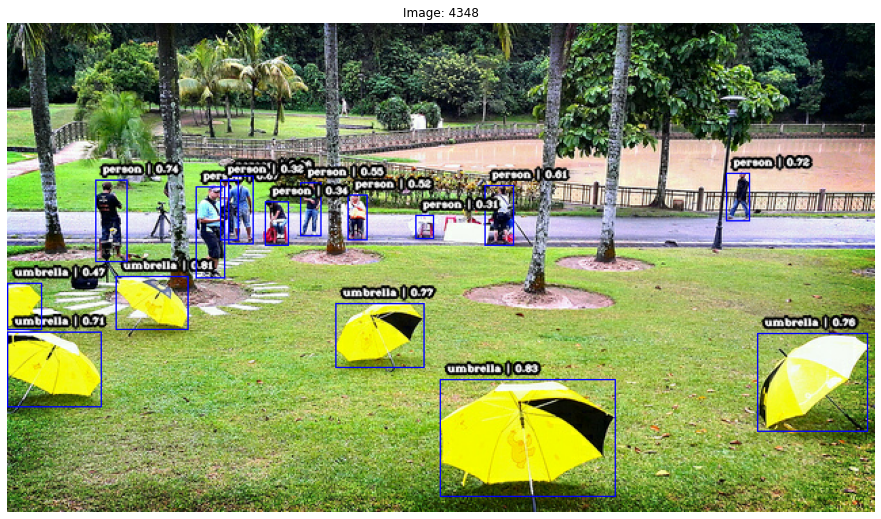

In [12]:
idx = 4348

image = read_image(image_paths[idx])
image_height, image_width, _ = image.get_shape().as_list()

serving_input = prepare_image_fn(image=image)
tik = time()
detections = serving_fn(serving_input['image'])
toc = time()

valid_detections = detections['valid_detections'][0].numpy()
boxes = detections['boxes'][0][:valid_detections].numpy()

# rescale box coordinates to original image space
boxes = boxes * np.maximum(image_height, image_width)

classes = [
    label_map[str(int(idx))]
    for idx in detections['classes'][0][:valid_detections].numpy()
]
scores = detections['scores'][0][:valid_detections].numpy()

#  Visualize detections
imshow(
    visualize_detections_cv2(
        image,
        boxes,
        classes,
        scores,
        score_threshold=0.30,
        save=False,
        filename='image_{}.png'.format(idx)),
    title='Image: {}'.format(idx),
)

print('Inference time: {:.2f} ms'.format((toc - tik) * 1000))

### Inference on a folder of  images

In [ ]:
fps = 1.0
num_samples = len(image_paths)

for idx, image_path in enumerate(image_paths):
    t1 = time()
    image = read_image(image_path)
    t2 = time()
    serving_input = prepare_image_fn(image=image)
    
    t3 = time()
    detections = serving_fn(image=serving_input['image'])
    t4 = time()
    
    fps = 0.95 * fps + 0.05 * (1 / (t4 - t3))
    eta = (num_samples - (idx + 1)) / fps

    print(
        '\rProcessed {}/{} images | ETA: {:.2f} secs | FPS(detection): {:.1f}/sec | forward_pass_with_nms: {:.3f} ms | image_reading: {:.3f} ms | image_preprocessing: {:.3f} ms'
        .format(idx + 1, len(image_paths), eta, fps, t4 - t3,
                t2 - t1, t3 - t2),
        end='')

### Inference on a webcam stream

In [11]:
fps_detection = 1.0
fps_end_to_end = 1.0
video = cv2.VideoCapture(0 + cv2.CAP_DSHOW)

video.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# video.set(cv2.CAP_PROP_FPS, 30)
video.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

while (True):
    t1 = time()
    ret, frame = video.read()
    t2 = time()

    frame = np.float32(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    image_height, image_width, _ = frame.shape
    serving_input = prepare_image_fn(image=frame)

    t3 = time()
    detections = serving_fn(image=serving_input['image'])
    t4 = time()

    fps_detection = 0.95 * fps_detection + 0.05 * (1 / (t4 - t3))
    fps_end_to_end = 0.95 * fps_end_to_end + 0.05 * (1 / (t4 - t1))

    valid_detections = detections['valid_detections'][0].numpy()
    
    boxes = detections['boxes'][0][:valid_detections].numpy()
    # rescale box coordinates to original image space
    boxes = boxes * np.maximum(image_height, image_width)

    classes = [
        label_map[str(int(idx))]
        for idx in detections['classes'][0][:valid_detections].numpy()
    ]
    scores = detections['scores'][0][:valid_detections].numpy()

    frame = visualize_detections_cv2(frame,
                                     boxes,
                                     classes,
                                     scores,
                                     score_threshold=0.5,
                                     save=False)

    info = 'FPS(detection): {:.1f}/sec | FPS(end_to_end): {:.1f}/sec | forward_pass_with_nms: {:.3f} ms | image_reading: {:.3f} ms | image_preprocessing: {:.3f} ms'.format(
        fps_detection, fps_end_to_end, t4 - t3, t2 - t1, t3 - t2)

    frame = cv2.putText(frame,
                        info, [25, 25],
                        cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        .6, [0, 0, 255],
                        1,
                        lineType=cv2.LINE_AA)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()